In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb

#### Load training and prediction window data from saved sql database

In [3]:
engine =create_engine('sqlite:///../Data/Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [4]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-07-27,76.37,4.2,Papua New Guinea,-5.297074,148.894953,63.765909,67.072000,79.460000,4.550000,4.573333,4.500000,1
1,2020-07-28,88.76,4.3,Papua New Guinea,-5.297074,148.894953,61.451364,67.670000,78.664286,4.540909,4.393333,4.485714,1
2,2020-07-29,83.01,4.4,Papua New Guinea,-5.297074,148.894953,64.770000,66.487333,86.885714,4.545455,4.366667,4.485714,1
3,2020-07-30,10.00,4.9,Papua New Guinea,-5.297074,148.894953,64.770000,64.040000,85.245714,4.545455,4.426667,4.571429,1
4,2020-07-31,195.88,4.3,Papua New Guinea,-5.297074,148.894953,73.219091,75.197333,102.524286,4.531818,4.426667,4.500000,1


In [5]:
engine =create_engine('sqlite:///../Data/Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [6]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-08-03,140.81,4.4,Papua New Guinea,-5.297074,148.894953,73.251364,70.354000,83.355714,4.718182,4.820000,4.942857,NaN
1,2020-08-04,172.48,5.4,Papua New Guinea,-5.297074,148.894953,76.803636,75.935333,106.567143,4.763636,4.893333,4.857143,NaN
2,2020-08-05,94.65,5.0,Papua New Guinea,-5.297074,148.894953,79.948636,76.711333,105.600000,4.790909,4.933333,4.971429,NaN
3,2020-08-06,196.24,4.8,Papua New Guinea,-5.297074,148.894953,87.892273,89.127333,113.395714,4.813636,4.926667,5.071429,NaN
4,2020-08-06,85.48,4.7,Papua New Guinea,-5.297074,148.894953,88.371818,81.767333,124.178571,4.809091,4.953333,4.914286,NaN


#### Training is done by considering 22, 15, 7 days window past features rolling average and outcome data is shifted to next 7 days as prediction.

In [7]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)
  

In [ ]:
features

#### Training phase

* Models used are : 
    * Adaboost classifier with DecisionTree 
    * Adaboost classifier with RandomForest
    * GridSearch CV as hyper parameter tunning
    

* Model used for Deployment of application :
    * Xgboost with parameters set from above models

#### Adaboost Decision Tree Classifier

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "estimator__max_depth": [2, 5, 7],
    "n_estimators": [200, 400, 600]
}

# Define base estimator
tree = DecisionTreeClassifier()

# AdaBoost classifier with correct param name
ABC = AdaBoostClassifier(
    estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME"  # spelling also fixed here
)

# Optional: hyperparameter tuning
#grid_search = GridSearchCV(estimator=ABC, param_grid=param_grid, cv=5)


#### Parameter tunning with GridSearch CV

In [11]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [12]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-master\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-master\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-master\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-m

GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [13]:
pred_ABC=grid_search_ABC.predict(X_test)

### Evaluation Area Under curve & ROC 

I have chose ROC_AUC score as evaluation metric since I have to binary classifify wether earthquake happened or not with given features that has been train on past few days window rolling average window.

 * With **adaboost decision tree classifier** and hyper parameter tunning, we get area under curve (score) = 0.8867
 * higher the auc score, better is the model since it is better at distinguishing postive and negative classes.
 * Make a note here that we get from **confusion matrix**, `False negative = 42`and `Recall score =0.7789`. We need this value apart from auc score that we will analyze later when we have tested with diffferent models below

0.8972322169941876
AUC: 0.8972


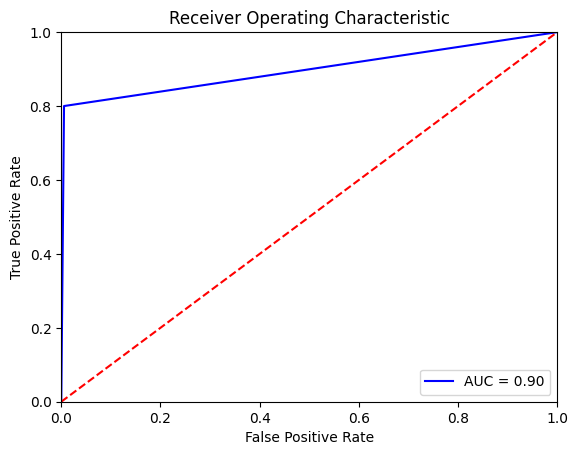

Confusion Matrix: 
 [[3593   20]
 [  38  152]]

Recall 'TP/TP+FN' =  0.8


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_ABC))
recall_adaboost=recall_score(y_test,pred_ABC)
accu_adaboost=np.round(roc_auc,4)


#### Adaboost Random Forest Classifier

In [16]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-master\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-master\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vyshu\Desktop\Harshita Semwal\Realtime Earthquake Pred\Realtime-Earthquake-forecasting-master\venv\Lib\site-packages\sklearn\ba

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [17]:
pred=CV_rfc.predict(X_test)

### Evaluation Area Under curve & ROC 

* Below is the auc score for **adaboost RandomForest classifier** with 0.916 which is slightly lower than Decision tree classifier
* Moreover when we look at **confusion matrix**, `False Negative=38` and `Recall score = 0.8' can be observed which is slightly higher than recall score of decision tree. Thus performs better than decision tree adabooost 

0.8966786603930251
AUC: 0.8967


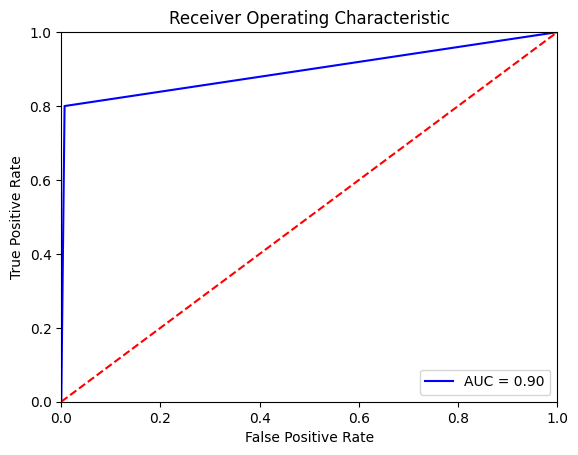

Confusion Matrix: 
 [[3589   24]
 [  38  152]]

Recall 'TP/TP+FN' =  0.8


In [18]:

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))
recall_random=recall_score(y_test,pred_ABC)
accu_random=np.round(roc_auc,4)

#### XGBoost 
* I have also tested with xgboost model below with similar parameters as I got above, since grid search CV was taking lot of time for xgboost.
 * As we can see this significantly gives higher AUC score of almost 0.0.98 and also `False negative = 37` which is similar Random Forest adaboost but xgboost has higher True positive and less False Positve compared to Random forest adaboost. i.e `Recall score = 0.805` which is similar adaboost Random Forrest tree. But XGboost is really good at classifying positive and negative classes and also better `aur_roc_score = 0.98193`. 

ROC AUC Score: 0.9766


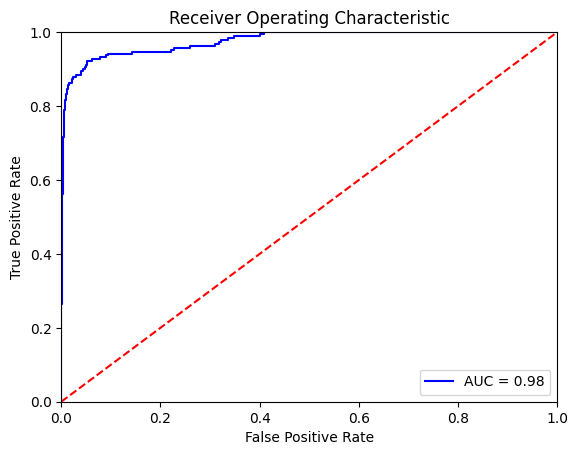

Confusion Matrix:
 [[3588   25]
 [  39  151]]

Recall (TP / (TP + FN)) = 0.7947


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, recall_score

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

# Set parameters
param = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.003,
    'verbosity': 0
}
num_round = 5000

# Train model
bst = xgb.train(param, dtrain, num_round)

# Predict probabilities
preds = bst.predict(dtest)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, preds)
print("ROC AUC Score:", np.round(roc_auc, 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, preds)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Binary classification
ypred_bst = (preds > 0.5).astype(int)

# Confusion Matrix & Recall
print("Confusion Matrix:\n", confusion_matrix(y_test, ypred_bst))
recall = recall_score(y_test, ypred_bst)
print("\nRecall (TP / (TP + FN)) =", np.round(recall, 4))

# Save scores
recall_xgboost = recall
accu_boost = np.round(roc_auc, 4)


We can see above that xgboost algorithm has higher auc score (0.9819) than adaboost decision tree and random forest, as it is evident from the ROC curve. Hence we consider xgboost for prediction of live data

### Final thoughts on which model to consider on application:
* Our main Aim is to predict wether earthquake will happen or not at a given day and place. So we definitely would **not like the model with higher False Neagtive values , since its more dangerous to predict as no earthquake while in reality earthquake happend than predicting earthquake will happen given in reality it did not**. Since its `better safe than sorry!!`, we can allow False positive more than False negative 

* After seeing these comparision on auc_roc score, confusion matrix, and recall score, since all the above algorithm have given similar result with slightly different recall scores, Xgboost with `FN=37` but with higher `auc_score 0f 0.98` performs over-all better. Hence for webapplication deployment, I have chosen Xgboost as it also faster than adaboost

#### Preparing prediction and plot for live unknown data we got in `df_predict` with `mag_outcome = Nan`

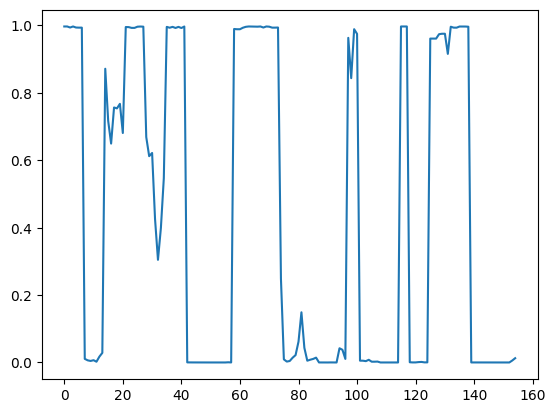

In [29]:

dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

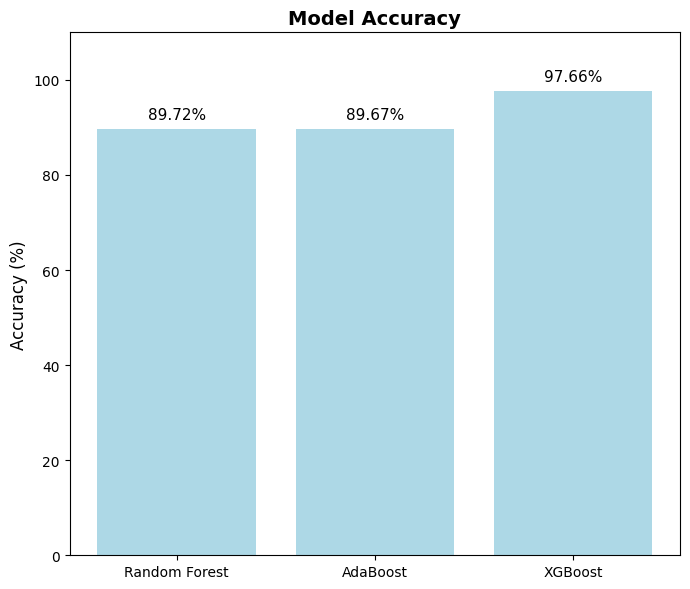

In [35]:
import matplotlib.pyplot as plt

# Algorithm names
algorithms = ['Random Forest', 'AdaBoost', 'XGBoost']

# Accuracy values (multiply by 100 to get percentage)
accuracy_values = [accu_adaboost * 100, accu_random * 100, accu_xgboost * 100]

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

# Accuracy bar plot
bars = ax.bar(algorithms, accuracy_values, color='lightblue')
ax.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_ylim(0, 110)  # Allow some space for labels above bars

# Add text labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.2f}%', ha='center', fontsize=11)

# Final layout
plt.tight_layout()
plt.show()


### Prediction 

* Select specific features such as `data`,`place`,`long`,`lat` and give earthquake probablity from prediction at that place and date as `quake` probability
* with taking only 7 days rolling period data from predict dataframe since this outcome value is NaN and we need to predict next 7 days period.

In [ ]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

In [ ]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

In [ ]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()